In [1]:
%load_ext autoreload
%autoreload 2

from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
style.use('seaborn-white')

# Large sensors

Find the ideal tiling for modules with 16x32 pixel sensors (TDR-like).

Inter-pixel gaps are not taken into account in this study. Just create a Sensor (taken as active area) and a module with a certain number of sensors along the x and y axis. For large sensors there are two sensors per module.


In [2]:
s = Sensor(42.5, 22)
m = Module(43.10, 56.50, n_sensor_x=1, n_sensor_y=2, sensor_distance_y=22.5, sensor_distance_x=42.5+0.1)

m.populate(s)

rb = ReadoutBoard(10,56.5, color='green')
pb = ReadoutBoard(10,29.5, color='red')

available = {}
filled = {}


### Get the numbers for the different versions

The ETL detector consists of 4 faces ("D1" - "D4"). We center the readout board on one side of the disk and the power board on the other side to get maximum coverage. Readout boards and modules can be powered from above or below, and to maximize coverage we can alternate this between the two disks.

In [3]:
large_sensor = {}

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

large_sensor['D1'] = Dee(315, 1185)
large_sensor['D1'].populate(SM, center_RB=True)

filled['above_RB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D1'].module_matrix ])
available['above_RB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D1'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

large_sensor['D2'] = Dee(315, 1185)
large_sensor['D2'].populate(SM, center_PB=True)

filled['above_PB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D2'].module_matrix ])
available['above_PB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D2'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

large_sensor['D3'] = Dee(315, 1185)
large_sensor['D3'].populate(SM, center_RB=True)

filled['below_RB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D3'].module_matrix ])
available['below_RB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D3'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

large_sensor['D4'] = Dee(315, 1185)
large_sensor['D4'].populate(SM, center_PB=True)

filled['below_PB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D4'].module_matrix ])
available['below_PB'] = sum( [ sum([ x for x in row if x==1]) for row in large_sensor['D4'].slot_matrix ])

In [4]:
large_sensor['D4'].supermodules[10].x1

311.19999999999993

In [5]:
tot_fill = filled['above_RB'] + filled['below_RB'] + filled['above_PB'] + filled['below_PB']
tot_fill*2

3936

In [6]:
tot_avail = available['above_RB'] + available['below_RB'] + available['above_PB'] + available['below_PB']
tot_avail*2

3936

In [7]:
tot_fill/tot_avail

1.0

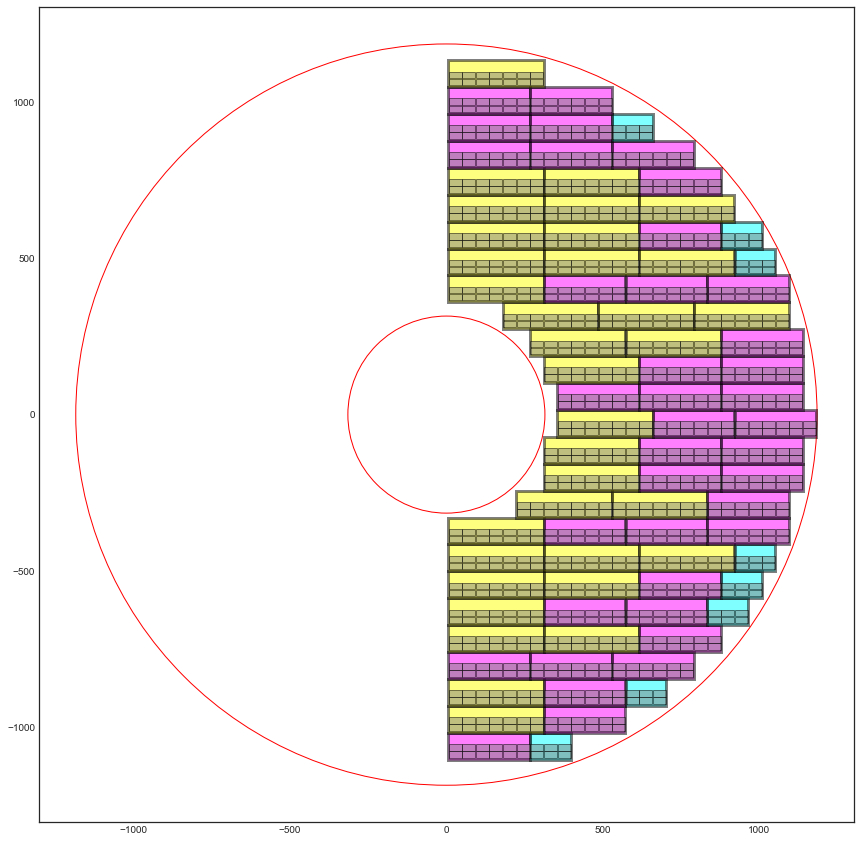

In [8]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for SM in large_sensor['D2'].supermodules:
    plt.gca().add_patch(SM.getPolygon())

for slot in large_sensor['D2'].slots_flat:
    if slot.covered:
        #plt.gca().add_patch(slot.getPolygon())
        #plt.gca().add_patch(slot.RB.getPolygon())
        #plt.gca().add_patch(slot.PB.getPolygon())
        for mod in slot.modules:
            for sen in mod.sensors:
                plt.gca().add_patch(sen.getPolygon(active=True))

#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

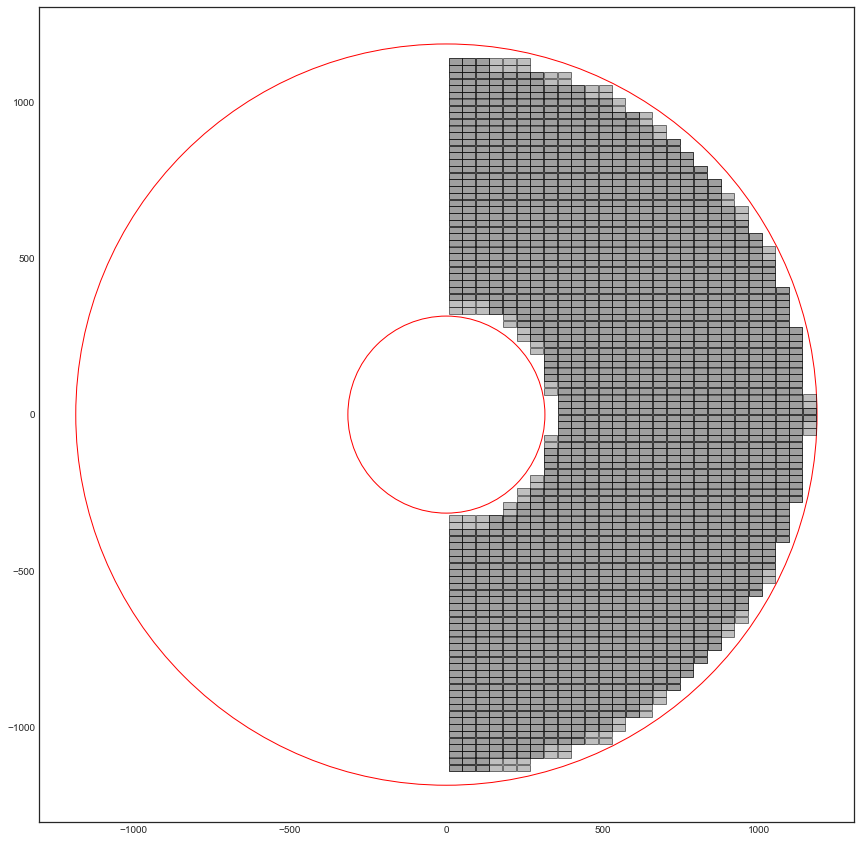

In [9]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in large_sensor:
    for slot in large_sensor[dee].slots_flat:
        if slot.covered:
            #plt.gca().add_patch(slot.getPolygon())
            #plt.gca().add_patch(slot.RB.getPolygon())
            #plt.gca().add_patch(slot.PB.getPolygon())
            for mod in slot.modules:
                for sen in mod.sensors:
                    plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

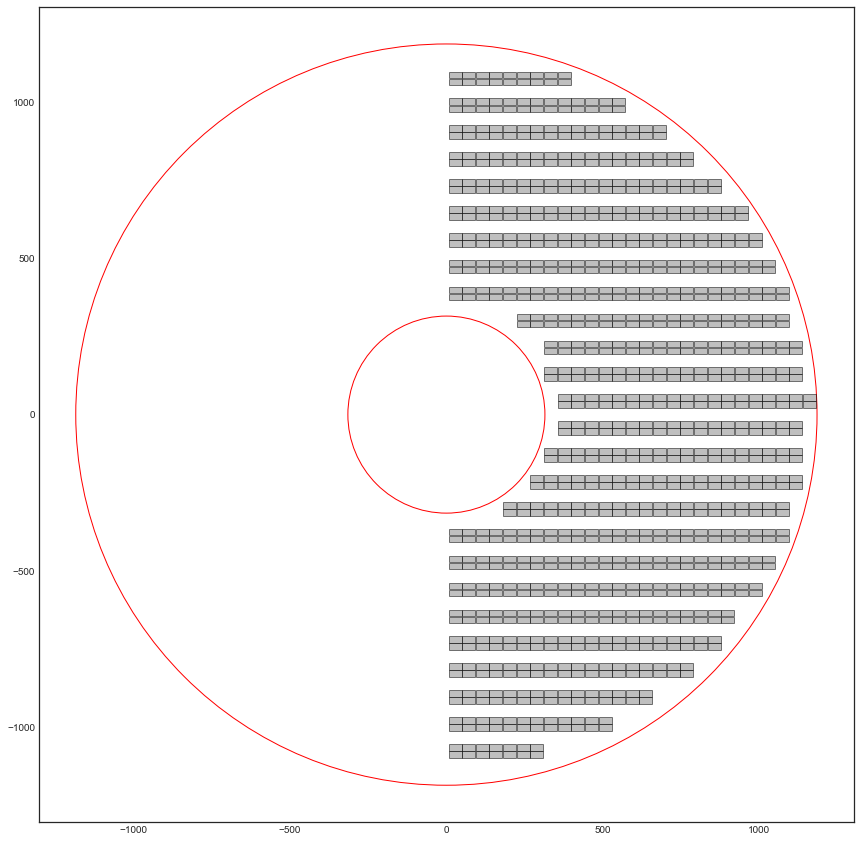

In [10]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for slot in large_sensor['D4'].slots_flat:
    if slot.covered:
        #plt.gca().add_patch(slot.getPolygon())
        #plt.gca().add_patch(slot.RB.getPolygon())
        #plt.gca().add_patch(slot.PB.getPolygon())
        for mod in slot.modules:
            for sen in mod.sensors:
                plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

In [11]:
## Alternative version with a small x and y shift of the second disk

large_sensor_v1 = {}

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

large_sensor_v1['D1'] = Dee(315, 1185)
large_sensor_v1['D1'].populate(SM, center_RB=True)

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

large_sensor_v1['D2'] = Dee(315, 1185)
large_sensor_v1['D2'].populate(SM, center_PB=True)

SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

large_sensor_v1['D3'] = Dee(315, 1185)
large_sensor_v1['D3'].populate(SM, center_RB=True, shift_x=2.5, shift_y=2.5)

SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

large_sensor_v1['D4'] = Dee(315, 1185)
large_sensor_v1['D4'].populate(SM, center_PB=True, shift_x=2.5, shift_y=2.5)

# Small sensors

16x16 sensors --> 2x2 sensors in a single module
Distances are defined from the centers of the sensors.

In [12]:
sensor_x = (42.5/2 + 0.5)
s = Sensor(sensor_x, 22)
m = Module(44.20, 56.50, n_sensor_x=2, n_sensor_y=2, sensor_distance_y=22.5, sensor_distance_x=sensor_x+0.1)

m.populate(s)

rb = ReadoutBoard(10,56.5, color='green')
pb = ReadoutBoard(10,29.5, color='red')

filled = {}
available = {}

### Get the numbers for the different versions

In [13]:
small_sensor = {}

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor['D1'] = Dee(315, 1185)
small_sensor['D1'].populate(SM, center_RB=True)

filled['above_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D1'].module_matrix ])
available['above_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D1'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor['D2'] = Dee(315, 1185)
small_sensor['D2'].populate(SM, center_PB=True)

filled['above_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D2'].module_matrix ])
available['above_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D2'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor['D3'] = Dee(315, 1185)
small_sensor['D3'].populate(SM, center_RB=True)

filled['below_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D3'].module_matrix ])
available['below_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D3'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor['D4'] = Dee(315, 1185)
small_sensor['D4'].populate(SM, center_PB=True)

filled['below_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D4'].module_matrix ])
available['below_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor['D4'].slot_matrix ])

In [14]:
tot_fill = filled['above_RB'] + filled['below_RB'] + filled['above_PB'] + filled['below_PB']
tot_fill*2

3852

In [15]:
tot_avail = available['above_RB'] + available['below_RB'] + available['above_PB'] + available['below_PB']
tot_avail*2

3856

In [16]:
tot_fill/tot_avail

0.9989626556016598

In [17]:
# Number of lost sensors (old size)
3848/3936

0.9776422764227642

So we would loose ~2% of the active area, mainly on the outer edge (low eta)

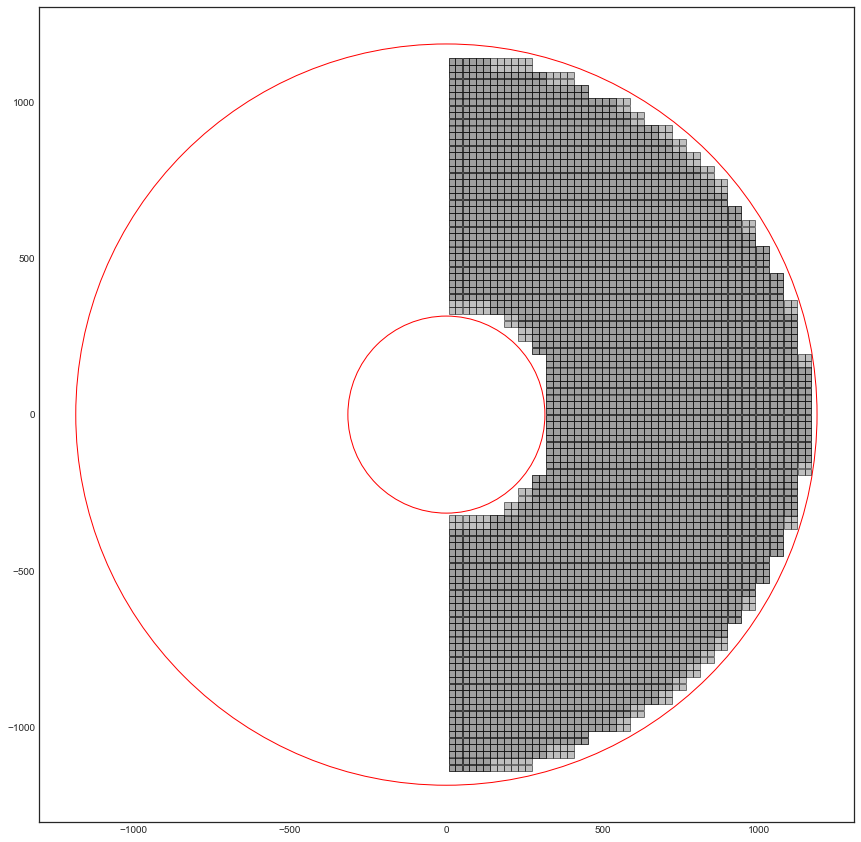

In [18]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in small_sensor:
    for slot in small_sensor[dee].slots_flat:
        if slot.covered:
            #plt.gca().add_patch(slot.getPolygon())
            #plt.gca().add_patch(slot.RB.getPolygon())
            #plt.gca().add_patch(slot.PB.getPolygon())
            for mod in slot.modules:
                for sen in mod.sensors:
                    plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

In [18]:
small_sensor_v1 = {}

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v1['D1'] = Dee(315, 1185)
small_sensor_v1['D1'].populate(SM, center_RB=True)

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v1['D2'] = Dee(315, 1185)
small_sensor_v1['D2'].populate(SM, center_PB=True)

SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor_v1['D3'] = Dee(315, 1185)
small_sensor_v1['D3'].populate(SM, center_RB=True, shift_x=2.5, shift_y=2.5)

SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor_v1['D4'] = Dee(315, 1185)
small_sensor_v1['D4'].populate(SM, center_PB=True, shift_x=2.5, shift_y=2.5)

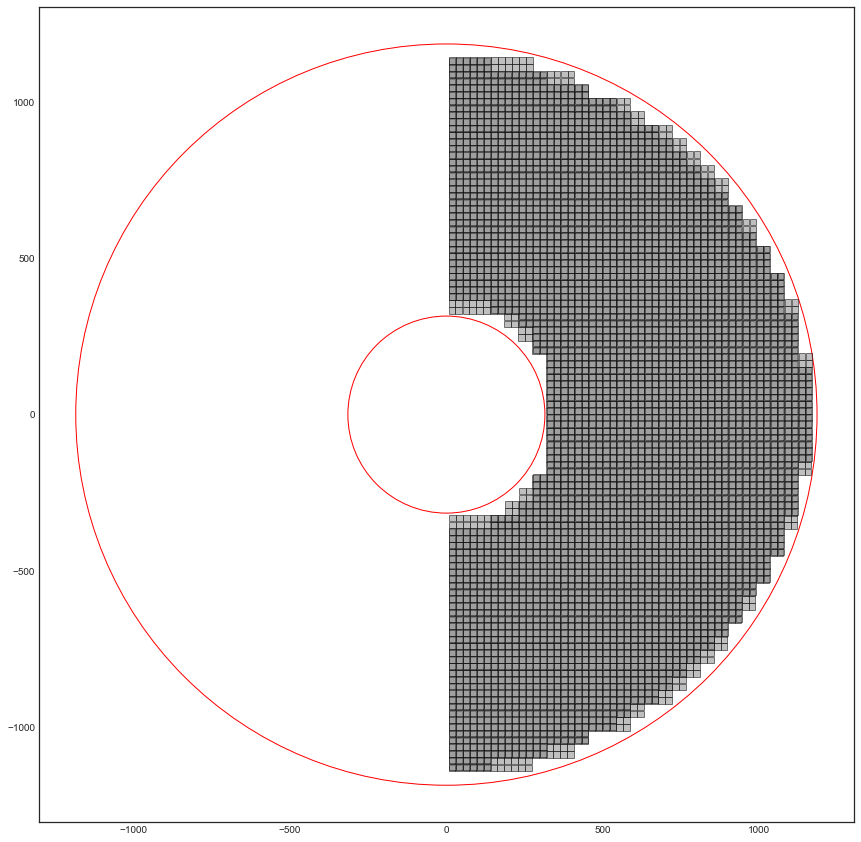

In [19]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in small_sensor_v1:
    for slot in small_sensor_v1[dee].slots_flat:
        if slot.covered:
            #plt.gca().add_patch(slot.getPolygon())
            #plt.gca().add_patch(slot.RB.getPolygon())
            #plt.gca().add_patch(slot.PB.getPolygon())
            for mod in slot.modules:
                for sen in mod.sensors:
                    plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

# Small sensors, small modules

In [20]:
sensor_x = (42.5/2 + 0.5)
s = Sensor(sensor_x, 22)
#m = Module(43.10/2, 56.50, n_sensor_x=1, n_sensor_y=2, sensor_distance_y=22.5, sensor_distance_x=sensor_x+0.1)

# this is the actual size, probably...
#42.5/2 + 0.5 + 0.6
m = Module(42.5/2 + 0.5 + 0.6, 56.50, n_sensor_x=1, n_sensor_y=2, sensor_distance_y=22.5, sensor_distance_x=sensor_x+0.1)

m.populate(s)

rb = ReadoutBoard(10,56.5, color='green')
pb = ReadoutBoard(10,29.5, color='red')

filled = {}
available = {}

flavors = [6,11,14]


In [21]:
small_sensor_v2 = {}

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v2['D1'] = Dee(315, 1185)
small_sensor_v2['D1'].populate(SM, flavors=flavors, center_RB=True)

filled['above_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D1'].module_matrix ])
available['above_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D1'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v2['D2'] = Dee(315, 1185)
small_sensor_v2['D2'].populate(SM, flavors=flavors, center_PB=True)

filled['above_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D2'].module_matrix ])
available['above_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D2'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor_v2['D3'] = Dee(315, 1185)
small_sensor_v2['D3'].populate(SM, flavors=flavors, center_RB=True, shift_x=0, shift_y=0)

filled['below_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D3'].module_matrix ])
available['below_RB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D3'].slot_matrix ])


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor_v2['D4'] = Dee(315, 1185)
small_sensor_v2['D4'].populate(SM, flavors=flavors, center_PB=True, shift_x=0, shift_y=0)

filled['below_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D4'].module_matrix ])
available['below_PB'] = sum( [ sum([ x for x in row if x==1]) for row in small_sensor_v2['D4'].slot_matrix ])

In [22]:
tot_fill = (filled['above_RB'] + filled['below_RB'] + filled['above_PB'] + filled['below_PB'])
tot_fill

3824

In [23]:
tot_avail = (available['above_RB'] + available['below_RB'] + available['above_PB'] + available['below_PB'])
tot_avail

3826

In [24]:
tot_fill/tot_avail

0.9994772608468374

In [25]:
3944/3936

1.0020325203252032

This would keep the number of sensor the same, but would require an "akward" redoutboard for 22 ETROCs -> essentially 5 full modules and one new half module

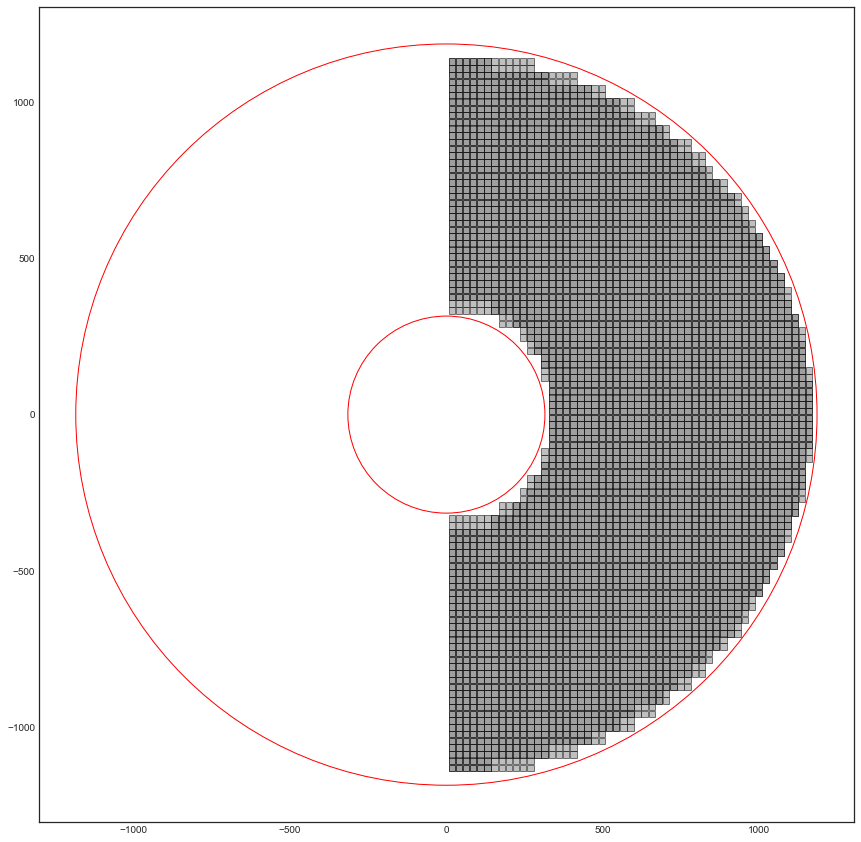

In [26]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in small_sensor_v2:
    for slot in small_sensor_v2[dee].slots_flat:
        if slot.covered:
            #plt.gca().add_patch(slot.getPolygon())
            #plt.gca().add_patch(slot.RB.getPolygon())
            #plt.gca().add_patch(slot.PB.getPolygon())
            for mod in slot.modules:
                for sen in mod.sensors:
                    plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

In [27]:
small_sensor_v2['D1'].intersect(100,510)

True

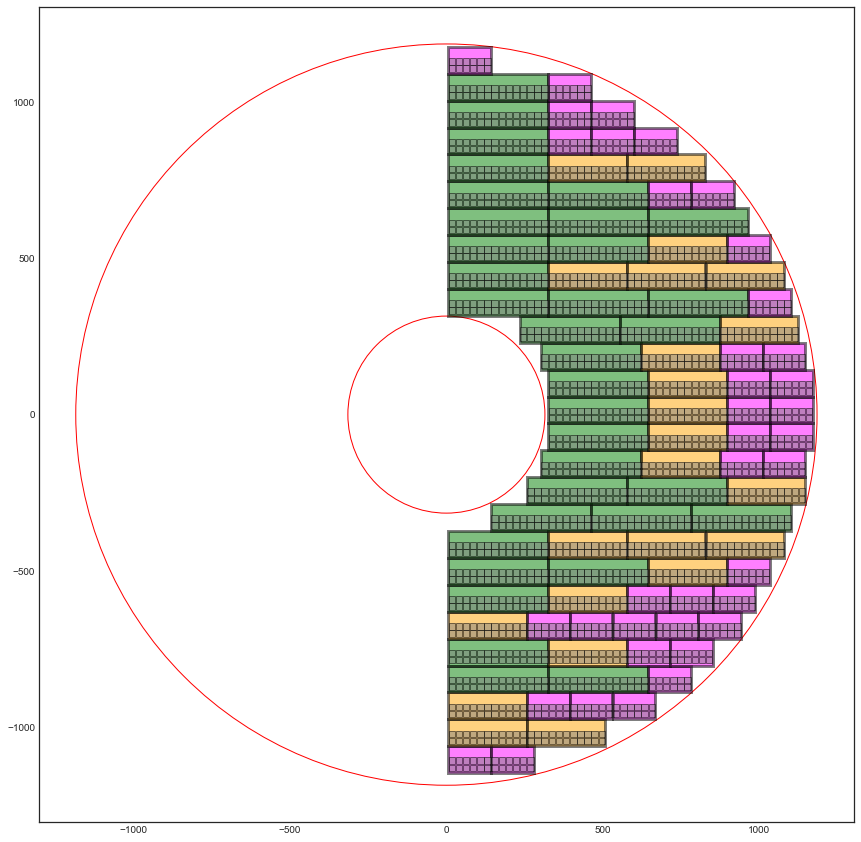

In [28]:
SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v2['D2'] = Dee(315, 1185)
small_sensor_v2['D2'].populate(SM, flavors=[6,12,14], center_PB=True)

inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for SM in small_sensor_v2['D1'].supermodules:
    plt.gca().add_patch(SM.getPolygon())

for slot in small_sensor_v2['D1'].slots_flat:
    if slot.covered:
        for mod in slot.modules:
            for sen in mod.sensors:
                plt.gca().add_patch(sen.getPolygon(active=True))

#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

## With some shift in x and y

This is done in order to also cover the inter-sensor and inter-module gaps. We are not yet considering inter-pixel gaps!


In [29]:
small_sensor_v3 = {}

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v3['D1'] = Dee(315, 1185)
small_sensor_v3['D1'].populate(SM, flavors=flavors, center_RB=True)


SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

small_sensor_v3['D2'] = Dee(315, 1185)
small_sensor_v3['D2'].populate(SM, flavors=flavors, center_PB=True)


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor_v3['D3'] = Dee(315, 1185)
small_sensor_v3['D3'].populate(SM, flavors=flavors, center_RB=True, shift_x=2.5, shift_y=2.5)


SM = SuperModule(m, pb, rb, n_modules=3, orientation='below')

small_sensor_v3['D4'] = Dee(315, 1185)
small_sensor_v3['D4'].populate(SM, flavors=flavors, center_PB=True, shift_x=2.5, shift_y=2.5)


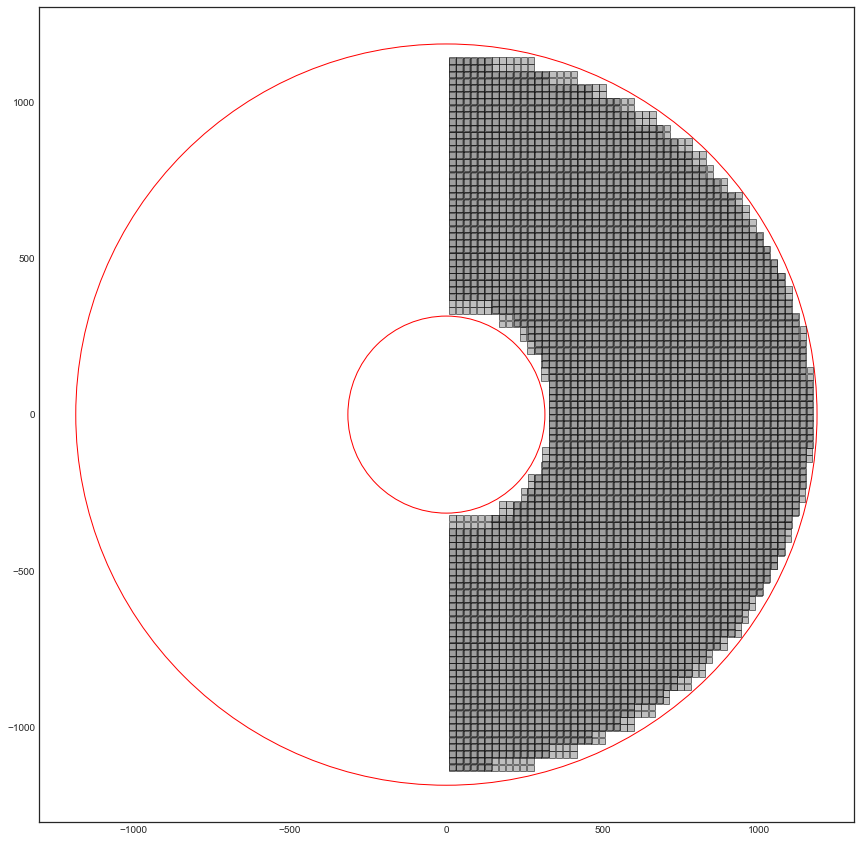

In [30]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in small_sensor_v3:
    for slot in small_sensor_v3[dee].slots_flat:
        if slot.covered:
            #plt.gca().add_patch(slot.getPolygon())
            #plt.gca().add_patch(slot.RB.getPolygon())
            #plt.gca().add_patch(slot.PB.getPolygon())
            for mod in slot.modules:
                for sen in mod.sensors:
                    plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

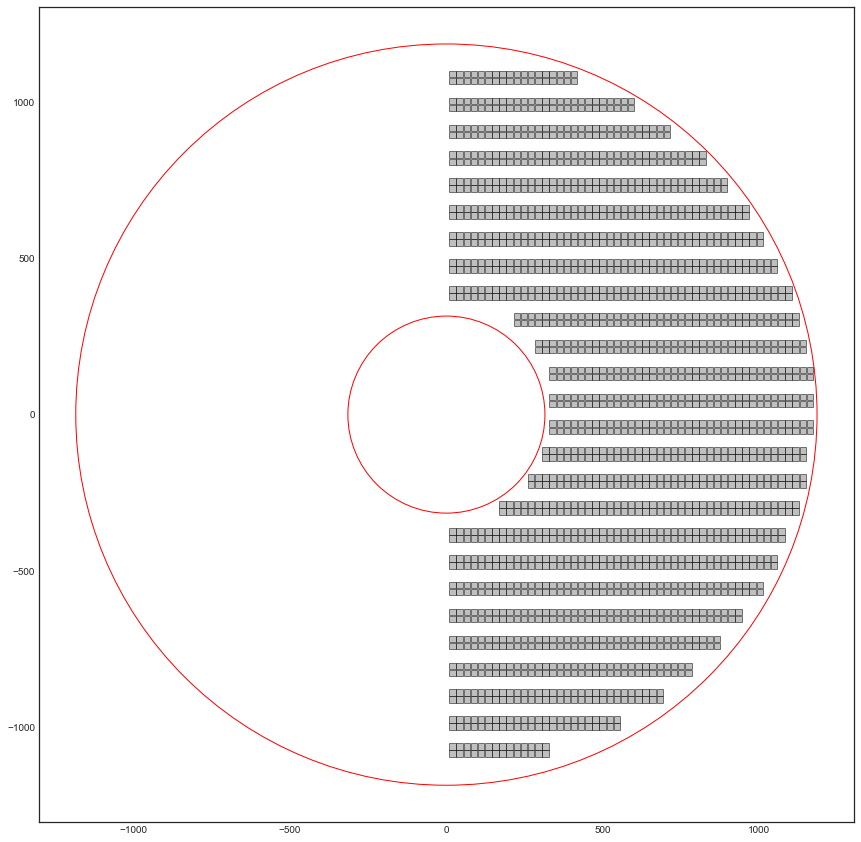

In [31]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for slot in small_sensor_v3['D4'].slots_flat:
    if slot.covered:
        #plt.gca().add_patch(slot.getPolygon())
        #plt.gca().add_patch(slot.RB.getPolygon())
        #plt.gca().add_patch(slot.PB.getPolygon())
        for mod in slot.modules:
            for sen in mod.sensors:
                plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

# TDR layout

In [32]:
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper


with open('layouts/database_TDR.yaml') as f:
    databaseTDR = load(f, Loader=Loader)

diskTDR = databaseTDR['TDR']


In [33]:
diskTDR['disk1']['back'] == diskTDR['disk2']['back']

True

In [34]:
TDR = {}

s = Sensor(42.5, 22)

TDR['D1'] = Dee(315, 1185)
TDR['D1'].fromCenters(diskTDR['disk1']['front'], s)

TDR['D2'] = Dee(315, 1185)
TDR['D2'].fromCenters(diskTDR['disk1']['back'], s)

TDR['D3'] = Dee(315, 1185)
TDR['D3'].fromCenters(diskTDR['disk2']['front'], s)

TDR['D4'] = Dee(315, 1185)
TDR['D4'].fromCenters(diskTDR['disk2']['back'], s)

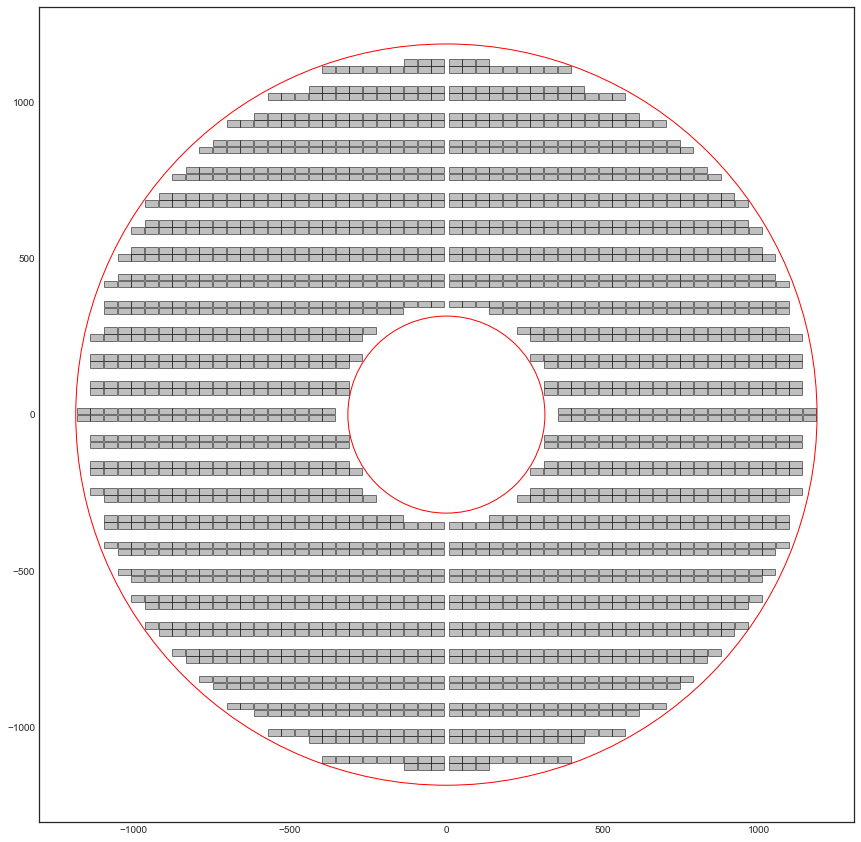

In [47]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in ['D2']:
    for sen in TDR[dee].sensors:
        plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

In [35]:
TDR['D2'].intersect(100,515)

True

In [36]:
(len(TDR['D1'].vax1) + len(TDR['D2'].vax1) + len(TDR['D3'].vax1) + len(TDR['D4'].vax1))*2

16176

## New Layout

In [37]:
# with open('new_layouts/database_new_filled.yaml') as f:
#     database_new_filled = load(f, Loader=Loader)

with open('new_layouts/database_new_unfilled.yaml') as f:
    database_new = load(f, Loader=Loader)

disk_new = database_new['new']

In [5]:
# new_layout_unpixeled = {}

# s = Sensor2(21.4, 21.6)

# new_layout_unpixeled['D1'] = Dee(315, 1185)
# new_layout_unpixeled['D1'].fromCenters(disk_new['disk1']['front'], s)

# new_layout_unpixeled['D2'] = Dee(315, 1185)
# new_layout_unpixeled['D2'].fromCenters(disk_new['disk1']['back'], s)

# new_layout_unpixeled['D3'] = Dee(315, 1185)
# new_layout_unpixeled['D3'].fromCenters(disk_new_unfilled['disk2']['front'], s)

# new_layout_unpixeled['D4'] = Dee(315, 1185)
# new_layout_unpixeled['D4'].fromCenters(disk_new_unfilled['disk2']['back'], s)

In [38]:
new_layout = {}
# m_pix = 16
# n_pix = 16
# gap = 0.05

s = Sensor2(21.4, 21.6)

# new_layout['D1'] = Dee(315, 1185)
# new_layout['D1'].fromCenters2(disk_new['disk1']['front'], s, m_pix, n_pix, gap)

# new_layout['D2'] = Dee(315, 1185)
# new_layout['D2'].fromCenters2(disk_new['disk1']['back'], s, m_pix, n_pix, gap)

# new_layout['D3'] = Dee(315, 1185)
# new_layout['D3'].fromCenters2(disk_new['disk2']['front'], s, m_pix, n_pix, gap)

# new_layout['D4'] = Dee(315, 1185)
# new_layout['D4'].fromCenters2(disk_new['disk2']['back'], s, m_pix, n_pix, gap)

new_layout['D1'] = Dee(315, 1185)
new_layout['D1'].fromCenters(disk_new['disk1']['front'], s)

new_layout['D2'] = Dee(315, 1185)
new_layout['D2'].fromCenters(disk_new['disk1']['back'], s)

new_layout['D3'] = Dee(315, 1185)
new_layout['D3'].fromCenters(disk_new['disk2']['front'], s)

new_layout['D4'] = Dee(315, 1185)
new_layout['D4'].fromCenters(disk_new['disk2']['back'], s)

In [31]:
for d in ['D1','D2','D3','D4']:
    inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
    outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

    plt.rcParams['figure.figsize'] = [15, 15]

    plt.gca().add_patch(inner)
    plt.gca().add_patch(outer)

    # for dee in ['D1']:#new_layout:
    for sen in new_layout[d].sensors:
        plt.gca().add_patch(sen.getPolygon(active=True))

    plt.axis('scaled')
    plt.savefig(f'test_filled_{d}.png')

    plt.clf()
            

<Figure size 1080x1080 with 0 Axes>

# Throwing random coordinates

In [39]:
class three_vector:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.r     = np.sqrt(x**2+y**2)
        self.theta = np.arctan2(self.r, z)
        self.eta   = -np.log(np.tan(self.theta/2))
        self.phi   = np.arctan2(y, x)
        
    @classmethod
    def fromEtaPhi(cls, eta, phi, z):
        cls.eta = eta
        cls.phi = phi
        cls.z = z
        cls.theta = 2*np.arctan(np.exp(cls.eta*(-1)))
        cls.r = z*np.tan(cls.theta)
        cls.x = cls.r*np.cos(cls.phi)
        cls.y = cls.r*np.sin(cls.phi)
        
        return cls
    
    

In [40]:
z_ref = 2.99825
z = [
    2.99825,
    3.0055,
    3.02075,
    3.0285,
]


In [41]:
(z[1] - z_ref)*1000

7.249999999999979

In [42]:
import time
import random

starttime = time.time()

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min

nEvents = int(1e5)

eta = np.random.rand(nEvents)*eta_range + eta_min
phi = np.random.rand(nEvents)*np.pi*2-np.pi

vec = three_vector.fromEtaPhi(eta, phi, np.ones(nEvents)*3000)

vec_list = []
for x,y in zip(vec.x, vec.y):
    vec_list.append(three_vector(x,y,3000))


In [43]:
hits = {
    'TDR':[],
    'large_sensor':[],
    #'large_sensor_v1':[], # with shift
    'small_sensor':[],
    #'small_sensor_v1':[], # with shift
    #'small_sensor_v2':[],
    #'small_sensor_v3':[], # with shift
    'new_layout': [],
       }
   
nHits = {
    'TDR':[],
    'large_sensor':[],
    #'large_sensor_v1':[], # with shift
    'small_sensor':[],
    #'small_sensor_v1':[], # with shift
    #'small_sensor_v2':[],
    #'small_sensor_v3':[], # with shift
    'new_layout': [],
}

detector_variants = {
    
    'large_sensor': large_sensor,
    #'large_sensor_v1': large_sensor_v1,
    'small_sensor': small_sensor,
    #'small_sensor_v1': small_sensor_v1,
    #'small_sensor_v2': small_sensor_v2,
    #'small_sensor_v3': small_sensor_v3,
    'TDR': TDR,
    'new_layout': new_layout,
        }

delta_z = 20.5 # approximated distance between similar layers (e.g. front disk1 - front disk 2)
# We also want to get the number of hits.
for v in vec_list:
    
    
    
    for det in detector_variants:
        n = 0
        iLayer = 0

        for layer in ['D1', 'D2', 'D3', 'D4']:
            x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
            y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
            x,y = ((v.x + x_shift), (v.y + y_shift))
                
            if detector_variants[det][layer].intersect(x, y):
                n += 1
            iLayer += 1
            
        if n>0: hits[det].append(v)
        nHits[det].append(n)
    
    

endtime = time.time()

print (endtime-starttime)

107.23601055145264


In [44]:
from yahist import Hist1D
from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy

In [45]:
test = Hist1D(nHits['new_layout'], bins="5,-0.5,4.5")
test

bin,content
"(-0.5,0.5)",24468 ± 156.423
"(0.5,1.5)",12563 ± 112.085
"(1.5,2.5)",61331 ± 247.651
"(2.5,3.5)",1638 ± 40.4722
"(3.5,4.5)",0 ± 0


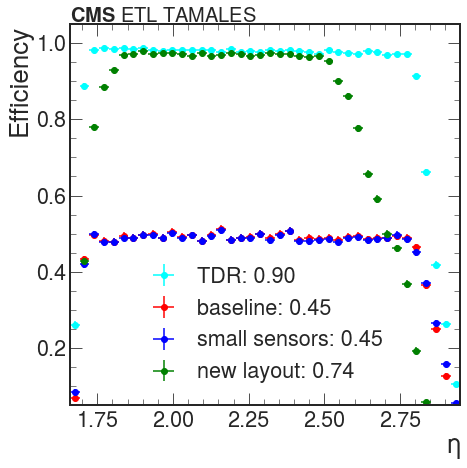

In [59]:
import os
import mplhep as hep

plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

bins = "40,1.659,2.950"

num0 = Hist1D([v.eta for v in hits['TDR']], bins=bins)
num1 = Hist1D([v.eta for v in hits['large_sensor']], bins=bins)
num2 = Hist1D([v.eta for v in hits['small_sensor']], bins=bins)
#num3 = Hist1D([v.eta for v in hits['small_sensor_v2']], bins=bins)
num3 = Hist1D([v.eta for v in hits['new_layout']], bins=bins)
#num4 = Hist1D([v.eta for v in hits['small_sensor_v3']], bins=bins)
#num5 = Hist1D([v.eta for v in hits['small_sensor_v1']], bins=bins)
#num6 = Hist1D([v.eta for v in hits['large_sensor_v1']], bins=bins)
den = Hist1D([v.eta for v in vec_list], bins=bins)

fig, ax = plt.subplots(1,1,figsize=(7,7))

h0 = num0.divide(den, binomial=True)
h1 = num1.divide(den, binomial=True)
h2 = num2.divide(den, binomial=True)
h3 = num3.divide(den, binomial=True)
#h4 = num4.divide(den, binomial=True)
#h5 = num5.divide(den, binomial=True)
#h6 = num6.divide(den, binomial=True)

h0.plot(show_errors=True, color="cyan", label='TDR: %.2f'%(len(hits['TDR'])/len(vec_list)))
h1.plot(show_errors=True, color="red", label='baseline: %.2f'%(len(hits['large_sensor'])/len(vec_list)))
#h6.plot(show_errors=True, color="black", label='baseline & shift: %.2f'%(len(hits['large_sensor_v1'])/len(vec_list)))
h2.plot(show_errors=True, color="blue", label='small sensors: %.2f'%(len(hits['small_sensor'])/len(vec_list)))
#h5.plot(show_errors=True, color="gray", label='small sensors & shift: %.2f'%(len(hits['small_sensor_v1'])/len(vec_list)))
#h3.plot(show_errors=True, color="green", label='small modules: %.2f'%(len(hits['small_sensor_v2'])/len(vec_list)))
h3.plot(show_errors=True, color="green", label='new layout: %.2f'%(len(hits['new_layout'])/len(vec_list)))
#h4.plot(show_errors=True, color="orange", label='small modules & shift: %.2f'%(len(hits['small_sensor_v3'])/len(vec_list)))

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\eta$')

ax.set_ylim(0.05,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency'

# fig.savefig(os.path.join("{}.pdf".format(name)))
# fig.savefig(os.path.join("{}.png".format(name)))

In [69]:
def getRadius(eta, z=3000):
    return z*np.tan( 2*np.arctan(np.exp(eta*(-1)) ) )

        #cls.theta = 2*np.arctan(np.exp(cls.eta*(-1)))
        #cls.r = z*np.tan(cls.theta)
getRadius(3, z=6000) 

598.9294180129365

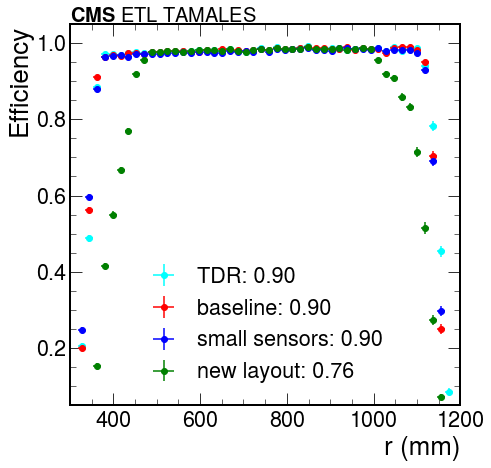

In [54]:


bins = "50,300,1200"

num0 = Hist1D([v.r for v in hits['TDR']], bins=bins)
num1 = Hist1D([v.r for v in hits['large_sensor']], bins=bins)
num2 = Hist1D([v.r for v in hits['small_sensor']], bins=bins)
#num3 = Hist1D([v.r for v in hits['small_sensor_v2']], bins=bins)
num3 = Hist1D([v.r for v in hits['new_layout']], bins=bins)
den = Hist1D([v.r for v in vec_list], bins=bins)

fig, ax = plt.subplots(1,1,figsize=(7,7))

h0 = num0.divide(den, binomial=True)
h1 = num1.divide(den, binomial=True)
h2 = num2.divide(den, binomial=True)
h3 = num3.divide(den, binomial=True)
#h4 = num4.divide(den, binomial=True)
#h5 = num5.divide(den, binomial=True)
#h6 = num6.divide(den, binomial=True)

h0.plot(show_errors=True, color="cyan", label='TDR: %.2f'%(len(hits['TDR'])/len(vec_list)))
h1.plot(show_errors=True, color="red", label='baseline: %.2f'%(len(hits['large_sensor'])/len(vec_list)))
#h6.plot(show_errors=True, color="black", label='baseline & shift: %.2f'%(len(hits['large_sensor_v1'])/len(vec_list)))
h2.plot(show_errors=True, color="blue", label='small sensors: %.2f'%(len(hits['small_sensor'])/len(vec_list)))
#h5.plot(show_errors=True, color="gray", label='small sensors & shift: %.2f'%(len(hits['small_sensor_v1'])/len(vec_list)))
#h3.plot(show_errors=True, color="green", label='small modules: %.2f'%(len(hits['small_sensor_v2'])/len(vec_list)))
h3.plot(show_errors=True, color="green", label='new layout: %.2f'%(len(hits['new_layout'])/len(vec_list)))
#h4.plot(show_errors=True, color="orange", label='small modules & shift: %.2f'%(len(hits['small_sensor_v3'])/len(vec_list)))

ax.set_ylabel('Efficiency')
ax.set_xlabel('r (mm)')

ax.set_ylim(0.05,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_vs_r'

# fig.savefig(os.path.join("{}.pdf".format(name)))
# fig.savefig(os.path.join("{}.png".format(name)))

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


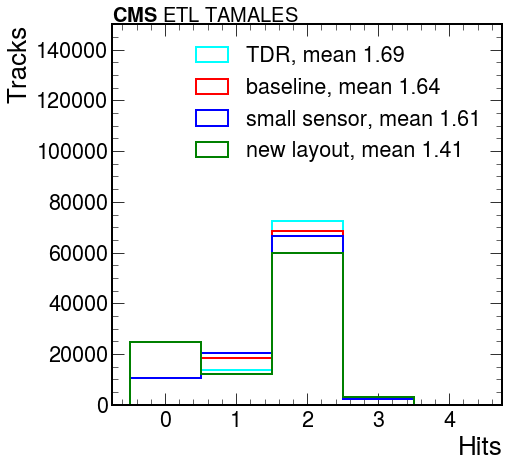

In [73]:
bins = "5,-0.5,4.5"

h0 = Hist1D(nHits['TDR'], bins=bins)
h1 = Hist1D(nHits['large_sensor'], bins=bins)
h2 = Hist1D(nHits['small_sensor'], bins=bins)
#h3 = Hist1D(nHits['small_sensor_v2'], bins=bins)
h3 = Hist1D(nHits['new_layout'], bins=bins)


fig, ax = plt.subplots(1,1,figsize=(7,7))
#fig, ax = plt.subplots(1,1)

h0.plot(color="cyan", histtype="step", linewidth=2, label='TDR, mean %.2f'%h0.mean())
h1.plot(color="red", histtype="step", linewidth=2, label='baseline, mean %.2f'%h1.mean())
h2.plot(color="blue", histtype="step", linewidth=2, label='small sensor, mean %.2f'%h2.mean())
#h3.plot(color="green", histtype="step", linewidth=2, label='small module, mean %.2f'%h3.mean())
h3.plot(color="green", histtype="step", linewidth=2, label='new layout, mean %.2f'%h3.mean())

ax.set_ylabel('Tracks')
ax.set_xlabel('Hits')

ax.set_ylim(0,nEvents*1.5)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'nHits'

fig.savefig(os.path.join("{}.pdf".format(name)))
fig.savefig(os.path.join("{}.png".format(name)))

## Old hit maps, currently might not work

In [ ]:
num1 = Hist1D([v.phi for v in hits['large_sensor']], bins="20,-%s,%s"%(np.pi/2,np.pi/2), label='baseline')
num2 = Hist1D([v.phi for v in hits['small_sensor']], bins="20,-%s,%s"%(np.pi/2,np.pi/2), label='small sensor')
num3 = Hist1D([v.phi for v in hits['small_sensor_v2']], bins="20,-%s,%s"%(np.pi/2,np.pi/2), label='small module')
num4 = Hist1D([v.phi for v in hits['small_sensor_v3']], bins="20,-%s,%s"%(np.pi/2,np.pi/2), label='small module & shift')
den = Hist1D([v.phi for v in vec_list], bins="20,-%s,%s"%(np.pi/2,np.pi/2))

h1 = num1.divide(den, binomial=True)
h2 = num2.divide(den, binomial=True)
h3 = num3.divide(den, binomial=True)
h4 = num4.divide(den, binomial=True)

fig, ax = plt.subplots(1,1,figsize=(7,7))


h1.plot(show_errors=True, color="red")
h2.plot(show_errors=True, color="blue")
h3.plot(show_errors=True, color="green")
h4.plot(show_errors=True, color="orange")

ax.set_ylim(0.45,1.05)

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\phi$')

fig.text(0.0, 0.995, r'$\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )



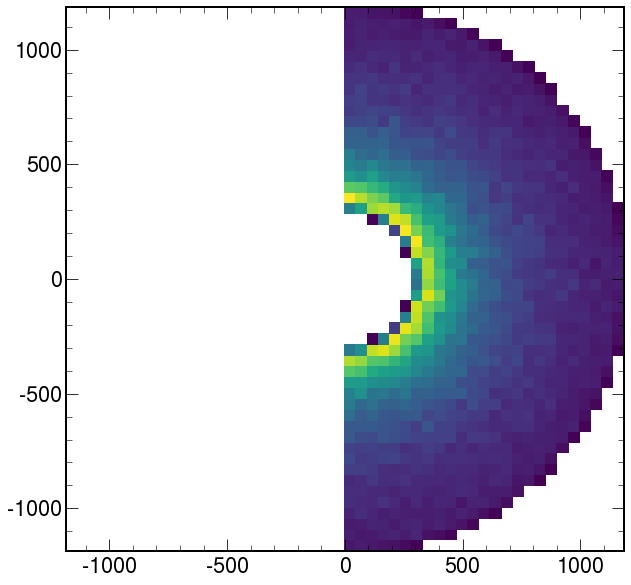

In [151]:
h_all, x_edge, y_edge, img = plt.hist2d([v.x for v in vec_list], [v.y for v in vec_list], bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

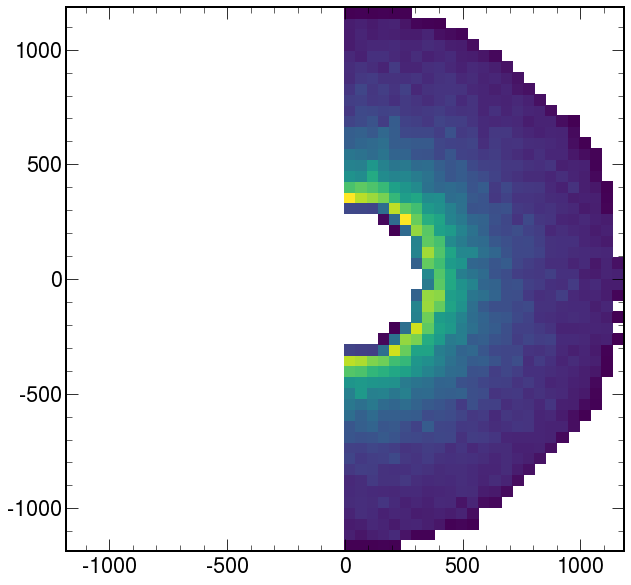

In [152]:
h_large_sensor, x_edge, y_edge, img = plt.hist2d([v.x for v in hits['large_sensor']], [v.y for v in hits['large_sensor']], bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

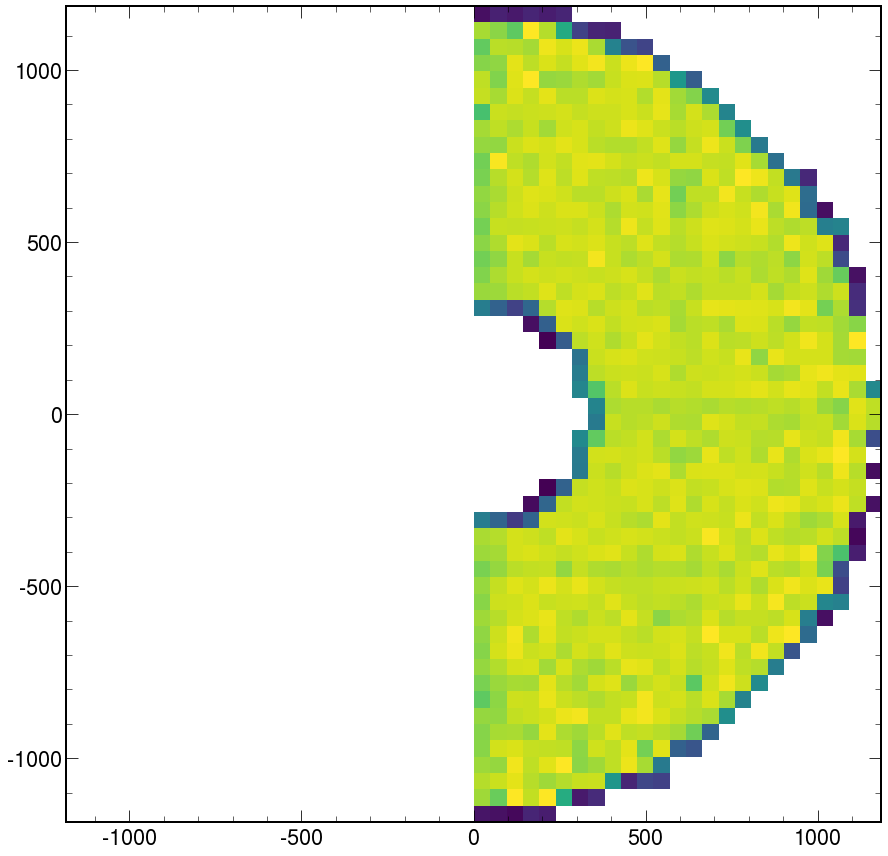

In [156]:
# TAMALES efficiencies
#H = np.nan_to_num(h_TAMALES_passed/h_all, -1)
H = h_large_sensor/h_all
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])




In [155]:
print ("# TAMALES baseline design:")
print ("  %.3f"%(float(len(hits['large_sensor']))/len(vec_list)))

# TAMALES baseline design:
  0.837


Seems like TAMALES baseline (large sensors) and small sensors with small modules have the same efficiency (85%), while small sensors/large modules gets reduced to 83%.

This does not yet take into account that we can shift the disks slightly to get rid of the inter-sensor gaps.

Shifting one disk by -6, 2 results in 94% efficiency! While the 6mm gap removal around x=0 may be the most obvious change, also shifting by 2,2 results in 93% efficiency. Just 0,2 results in ~88%. Just 2,0 results in  ~90%.


In [51]:
42.5/2 + 0.5 + 0.6

22.35